In [1]:
import numpy as np
import random
import pandas as pd
#!pip install lifelines
import lifelines
from lifelines import CoxPHFitter
import xlrd

In [2]:
import numpy as np
# Creating Dummy Data.
# time_ls - Time since last service.
time_ls = np.arange(1, 12)

# service_flg - Service required 1 - Yes, 0 - No.
service_flg = [1, 0]

# subscriber - Number of subscriber pinging the base station.
subscriber = [10, 15, 20, 25, 30]

# region - 1 - City, 0 - Remote Station (Mountains, Remote Locations).
region = [1, 0]


In [3]:
def get_dummy_data(dataframe,
                   column,
                   vector,
                   size):
    data = [random.choice(vector)for ele in range(size)]
    dataframe[column] = data
    return dataframe

In [4]:
vector_arr = [time_ls, subscriber, region, service_flg]
size = 1000
columns_arr = ["Time_Since_Service", "Subscribers", "Region", "Service_Flag"]

dataframe = pd.DataFrame()

for idx, ele in enumerate(vector_arr):
    dataframe = get_dummy_data(dataframe, columns_arr[idx], ele, size=size)


In [5]:
dataframe.head()

,Time_Since_Service,Subscribers,Region,Service_Flag
0,10,25,0,0
1,4,10,0,1
2,1,15,1,1
3,9,25,1,1
4,5,10,1,0


In [6]:
def cox_hazard_mdl(cox_mdl_object,dataframe, event, series):
    
    # Cox Proportional Hazards model.
    # Instantiate the class and create a model object.
   
    # Fit the training data.
    cox_mdl_object.fit(dataframe, series, event_col=event)
    
    # Model summary.
    cox_mdl_object.print_summary()
    
    return cox_mdl_object

In [7]:

event = "Service_Flag"
series = "Time_Since_Service"
cx_mdl = CoxPHFitter()
model = cox_hazard_mdl(cx_mdl,
                       dataframe,
                       event,
                       series)

<lifelines.CoxPHFitter: fitted with 1000 total observations, 510 right-censored observations>
             duration col = 'Time_Since_Service'
                event col = 'Service_Flag'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 490
   partial log-likelihood = -2940.25
         time fit was run = 2021-05-13 18:25:47 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
Subscribers   0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
Region        0.01       1.01       0.09            -0.17             0.18                 0.84                 1.20

               z    p   -log2(p)
covariate                       
Subscribers 0.13 0.89       0.16
Region      0.07 0.95       0.08
---
Concordance = 0.49
Partial AIC = 5884.50
log-likelihood ratio test = 0.02 on 2 df
-log2(p) of ll-ratio test = 0.02

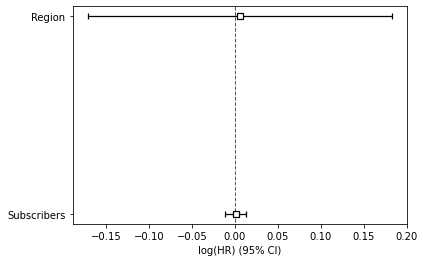

In [8]:
model.plot()

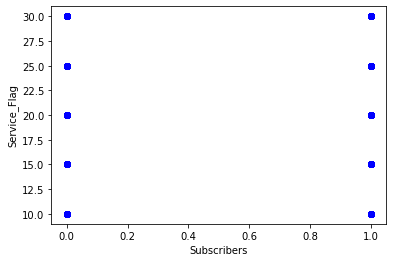

In [9]:
import matplotlib.pyplot as plt
plt.scatter(dataframe.Service_Flag,  dataframe.Subscribers, color='blue')
plt.xlabel("Subscribers")
plt.ylabel("Service_Flag")
plt.show()

## Using the mock data Prepared

In [10]:
# data_sample_df = pd.read_excel(open('Data Sample.xlsx','rb'),
#                                sheet_name = "TimeSeries")

data_sample_df = pd.read_csv("TimeSeries_survivaldata.csv")
data_sample_df.head()

def split_and_multiply(X):
    
    number = int(X.split(" ")[0])
    scale = X.split(" ")[1]
    #print("The number is {} and scale is {}".format(number,scale))
    
    if(scale == "Mn"):
        y = number*10e6
    
    return y
    

split_and_multiply("10 Mn")
data_sample_df['SNO'] = data_sample_df["Subscriber Number"].apply(lambda x : split_and_multiply(x))
data_sample_df.head()

,Tower Id,Cell Tower Name,Tenure (Month),Service Flag,Age,Subscriber Number,Region,SNO
0,1,NJ Jersey City,12,1,10,10 Mn,City,100000000.0
1,1,NJ Jersey City,11,0,10,10 Mn,City,100000000.0
2,1,NJ Jersey City,10,0,10,10 Mn,City,100000000.0
3,1,NJ Jersey City,9,0,10,10 Mn,City,100000000.0
4,1,NJ Jersey City,8,1,10,10 Mn,City,100000000.0


In [11]:
#Label encode region 
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
data_sample_df['Region_Cat'] = labelencoder.fit_transform(data_sample_df['Region'])
data_sample_df['Region_Cat'].value_counts()


1    24
0    24
Name: Region_Cat, dtype: int64

In [52]:
dataset =  data_sample_df.drop(columns = ["Cell Tower Name","Region","Subscriber Number"])
dataset.head()
## Create dummy variables
df_dummy = pd.get_dummies(dataset, drop_first=True)
df_dummy.head()

,Tower Id,Tenure (Month),Service Flag,Age,SNO,Region_Cat
0,1,12,1,10,100000000.0,0
1,1,11,0,10,100000000.0,0
2,1,10,0,10,100000000.0,0
3,1,9,0,10,100000000.0,0
4,1,8,1,10,100000000.0,0


# Model 1 : Using l1_ratio = 1 without Statifying 

https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html

In [96]:
# In how many months we need for the next Service 

event = "Service Flag"
series = "Tenure (Month)"
cx_mdl_lasso = CoxPHFitter(l1_ratio = 1,penalizer = 0.01)
base_lasso_model = cox_hazard_mdl(cx_mdl_lasso,
                            df_dummy,
                       event,
                       series)
base_lasso_model.baseline_hazard_

<lifelines.CoxPHFitter: fitted with 48 total observations, 38 right-censored observations>
             duration col = 'Tenure (Month)'
                event col = 'Service Flag'
                penalizer = 0.01
                 l1 ratio = 1
      baseline estimation = breslow
   number of observations = 48
number of events observed = 10
   partial log-likelihood = -22.04
         time fit was run = 2021-05-14 17:45:01 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
Tower Id    -0.21       0.81       0.34            -0.87             0.44                 0.42                 1.56
Age          0.03       1.03       0.04            -0.05             0.11                 0.95                 1.12
SNO          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Region_Cat  -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02

               z    p   -log2(p)
covariate                       
Tower Id   -0.64 0.52       0.93
Age         0.81 0.42       1.26
SNO         0.00 1.00       0.00
Region_Cat -0.00 1.00       0.00
---
Concordance = 0.72
Partial AIC = 52.09
log-likelihood ratio test = 1.61 on 4 df
-log2(p) of ll-ratio test = 0.31

,baseline hazard
1.0,0.000000
2.0,0.000000
3.0,0.022911
4.0,0.025457
5.0,0.000000
6.0,0.065461
7.0,0.000000
8.0,0.045822
9.0,0.057278
10.0,0.000000


Concordance Index
Another censoring-sensitive measure is the concordance-index, also known as the c-index. This measure evaluates the accuracy of the ranking of predicted time. It is in fact a generalization of AUC, another common loss function, and is interpreted similarly:

0.5 is the expected result from random predictions,

1.0 is perfect concordance and,

0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)

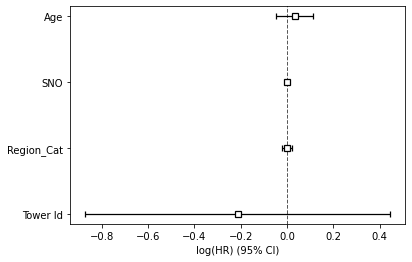

In [97]:
base_lasso_model.plot()

In [100]:
print("Predictions are \n",base_lasso_model.predict_expectation(df_dummy))
df_dummy.head(1)

Predictions are 
 0      9.297898
1      9.297898
2      9.297898
3      9.297898
4      9.297898
5      9.297898
6      9.297898
7      9.297898
8      9.297898
9      9.297898
10     9.297898
11     9.297898
12     8.878605
13     8.878605
14     8.878605
15     8.878605
16     8.878605
17     8.878605
18     8.878605
19     8.878605
20     8.878605
21     8.878605
22     8.878605
23     8.878605
24     9.733140
25     9.733140
26     9.733140
27     9.733140
28     9.733140
29     9.733140
30     9.733140
31     9.733140
32     9.733140
33     9.733140
34     9.733140
35     9.733140
36    10.187118
37    10.187118
38    10.187118
39    10.187118
40    10.187118
41    10.187118
42    10.187118
43    10.187118
44    10.187118
45    10.187118
46    10.187118
47    10.187118
dtype: float64


,Tower Id,Tenure (Month),Service Flag,Age,SNO,Region_Cat
0,1,12,1,10,100000000.0,0


In [104]:
print("Predictions are \n",lasso_model.predict_survival_function(df_dummy.head(1)))


Predictions are 
              0
1.0   1.000000
2.0   1.000000
3.0   1.000000
4.0   0.894839
5.0   0.894839
6.0   0.894839
7.0   0.894839
8.0   0.732632
9.0   0.732632
10.0  0.732632
11.0  0.732632
12.0  0.269520


# Tenure is a good predictor with p value as well as from Confidence intervals. 

# Model 2 : Using strata = "Tower Id"

In [92]:
event = "Service Flag"
series = "Tenure (Month)"
cx_mdl_lasso = CoxPHFitter(l1_ratio = 1,penalizer = 0.01
                          strata = 'Tower Id')
lasso_model = cox_hazard_mdl(cx_mdl_lasso,
                            df_dummy,
                       event,
                       series)
lasso_model.baseline_hazard_

model,lifelines.CoxPHFitter
duration col,'Tenure (Month)'
event col,'Service Flag'
penalizer,0.01
l1 ratio,1
strata,Tower Id
baseline estimation,breslow
number of observations,48
number of events observed,10
partial log-likelihood,-12.92
time fit was run,2021-05-14 17:39:18 UTC


,1,2,3,4
1.0,0.000000,0.000000,0.000000,0.0
2.0,0.000000,0.000000,0.000000,0.0
3.0,0.000000,0.100000,0.000000,0.0
4.0,0.111111,0.000000,0.000000,0.0
5.0,0.000000,0.000000,0.000000,0.0
6.0,0.000000,0.142857,0.142857,0.0
7.0,0.000000,0.000000,0.000000,0.0
8.0,0.200000,0.000000,0.000000,0.0
9.0,0.000000,0.250000,0.000000,0.0
10.0,0.000000,0.000000,0.000000,0.0


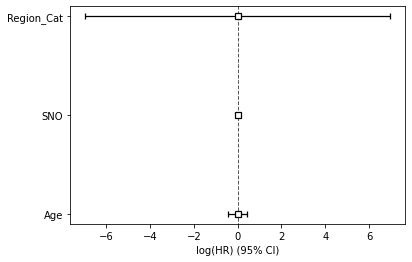

In [93]:
lasso_model.plot()

In [94]:
print("Predictions are \n",lasso_model.predict_expectation(df_dummy))


Predictions are 
 0      9.144647
1      9.144647
2      9.144647
3      9.144647
4      9.144647
5      9.144647
6      9.144647
7      9.144647
8      9.144647
9      9.144647
10     9.144647
11     9.144647
12     8.512663
13     8.512663
14     8.512663
15     8.512663
16     8.512663
17     8.512663
18     8.512663
19     8.512663
20     8.512663
21     8.512663
22     8.512663
23     8.512663
24     9.860721
25     9.860721
26     9.860721
27     9.860721
28     9.860721
29     9.860721
30     9.860721
31     9.860721
32     9.860721
33     9.860721
34     9.860721
35     9.860721
36    10.683940
37    10.683940
38    10.683940
39    10.683940
40    10.683940
41    10.683940
42    10.683940
43    10.683940
44    10.683940
45    10.683940
46    10.683940
47    10.683940
dtype: float64


,Tower Id,Tenure (Month),Service Flag,Age,SNO,Region_Cat
0,1,12,1,10,100000000.0,0


Text(0.5, 1.0, 'Survival function')

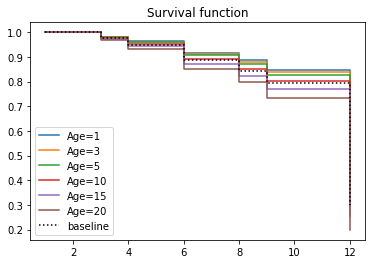

In [90]:
lasso_model.plot_partial_effects_on_outcome('Age',values = [1,3,5,10,15,20])
plt.title('Survival function')